In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

In [10]:
energy = pd.read_csv('./energy.csv', index_col=0)


In [11]:
energy.drop(['temp'], axis=1, inplace=True)

In [12]:
energy.head()

,load
timestamp,
2012-01-01 00:00:00,2698.0
2012-01-01 01:00:00,2558.0
2012-01-01 02:00:00,2444.0
2012-01-01 03:00:00,2402.0
2012-01-01 04:00:00,2403.0


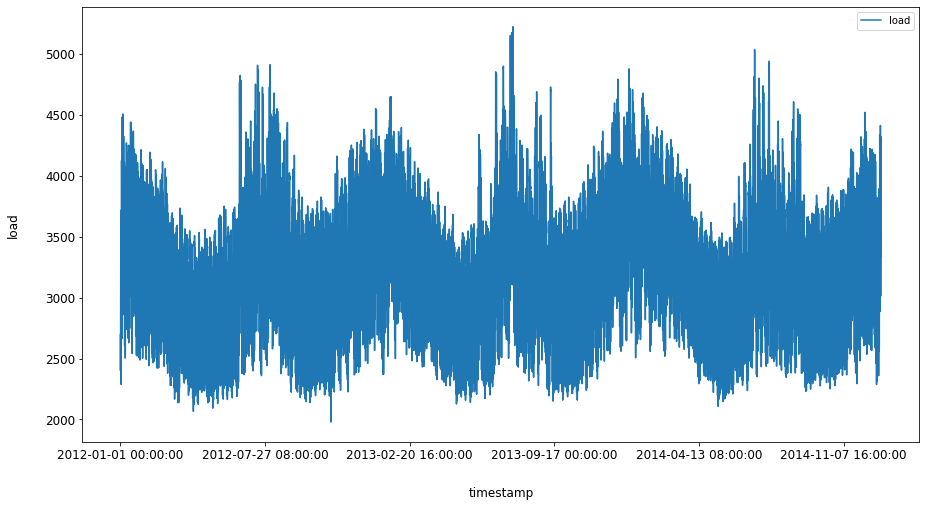

In [18]:
energy.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12, labelpad=25)
plt.ylabel('load', fontsize=12, labelpad=25)
plt.show()

In [19]:
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'

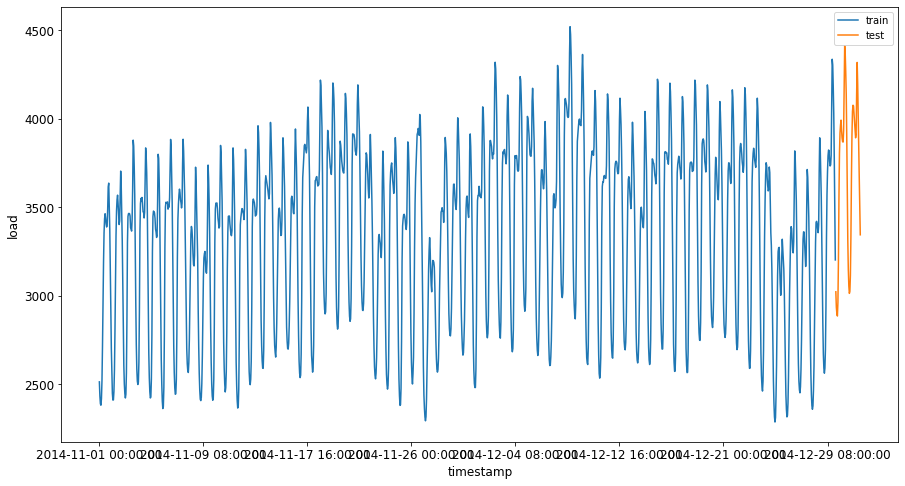

In [22]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [72]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


In [81]:
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
test['load'] = scaler.transform(test)

In [83]:
test.head()

,load
timestamp,
2014-12-30 00:00:00,0.329454
2014-12-30 01:00:00,0.290063
2014-12-30 02:00:00,0.273948
2014-12-30 03:00:00,0.268129
2014-12-30 04:00:00,0.302596


In [84]:
# Converting to numpy arrays
train_data = train.values
test_data = test.values

In [89]:
timesteps=5

train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(1412, 5)

In [98]:
train_data_timesteps

array([[0.10161146, 0.06580125, 0.04610564, 0.04252462, 0.05908684],
       [0.06580125, 0.04610564, 0.04252462, 0.05908684, 0.10429722],
       [0.04610564, 0.04252462, 0.05908684, 0.10429722, 0.19113697],
       ...,
       [0.91763653, 0.90331244, 0.84870188, 0.78155774, 0.66741271],
       [0.90331244, 0.84870188, 0.78155774, 0.66741271, 0.52461952],
       [0.84870188, 0.78155774, 0.66741271, 0.52461952, 0.41002686]])

In [90]:
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(44, 5)

In [91]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1412, 4) (1412, 1)
(44, 4) (44, 1)


In [99]:
x_train

array([[0.10161146, 0.06580125, 0.04610564, 0.04252462],
       [0.06580125, 0.04610564, 0.04252462, 0.05908684],
       [0.04610564, 0.04252462, 0.05908684, 0.10429722],
       ...,
       [0.91763653, 0.90331244, 0.84870188, 0.78155774],
       [0.90331244, 0.84870188, 0.78155774, 0.66741271],
       [0.84870188, 0.78155774, 0.66741271, 0.52461952]])

In [92]:
model = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)

In [93]:
model.fit(x_train, y_train[:,0])


SVR(C=10, epsilon=0.05, gamma=0.5)

In [94]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(1412, 1) (44, 1)


In [95]:
# Scaling the predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

print(len(y_train_pred), len(y_test_pred))

1412 44


In [96]:
# Scaling the original values
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

print(len(y_train), len(y_test))

1412 44


In [97]:
train_timestamps = energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = energy[test_start_dt:].index[timesteps-1:]

print(len(train_timestamps), len(test_timestamps))

1412 44


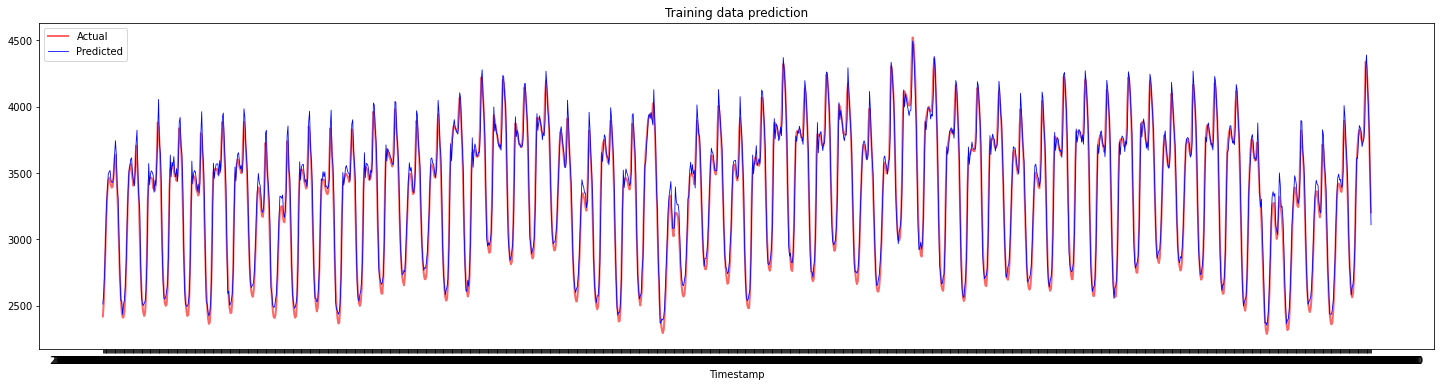

In [100]:
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

In [102]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [111]:
print('MAPE for training data: ', mean_absolute_percentage_error(y_train_pred, y_train), '%')

MAPE for training data:  1.70650417148503 %


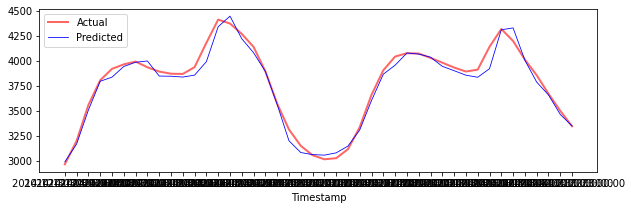

In [112]:
plt.figure(figsize=(10,3))
plt.plot(test_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

In [113]:
print('MAPE for testing data: ', mean_absolute_percentage_error(y_test_pred, y_test), '%')

MAPE for testing data:  1.2820913579708708 %


In [114]:
# Extracting load values as numpy array
data = energy.copy().values

# Scaling
data = scaler.transform(data)

# Transforming to 2D tensor as per model input requirement
data_timesteps=np.array([[j for j in data[i:i+timesteps]] for i in range(0,len(data)-timesteps+1)])[:,:,0]
print("Tensor shape: ", data_timesteps.shape)

# Selecting inputs and outputs from data
X, Y = data_timesteps[:,:timesteps-1],data_timesteps[:,[timesteps-1]]
print("X shape: ", X.shape,"\nY shape: ", Y.shape)

Tensor shape:  (26300, 5)
X shape:  (26300, 4) 
Y shape:  (26300, 1)


In [115]:
# Make model predictions
Y_pred = model.predict(X).reshape(-1,1)

# Inverse scale and reshape
Y_pred = scaler.inverse_transform(Y_pred)
Y = scaler.inverse_transform(Y)

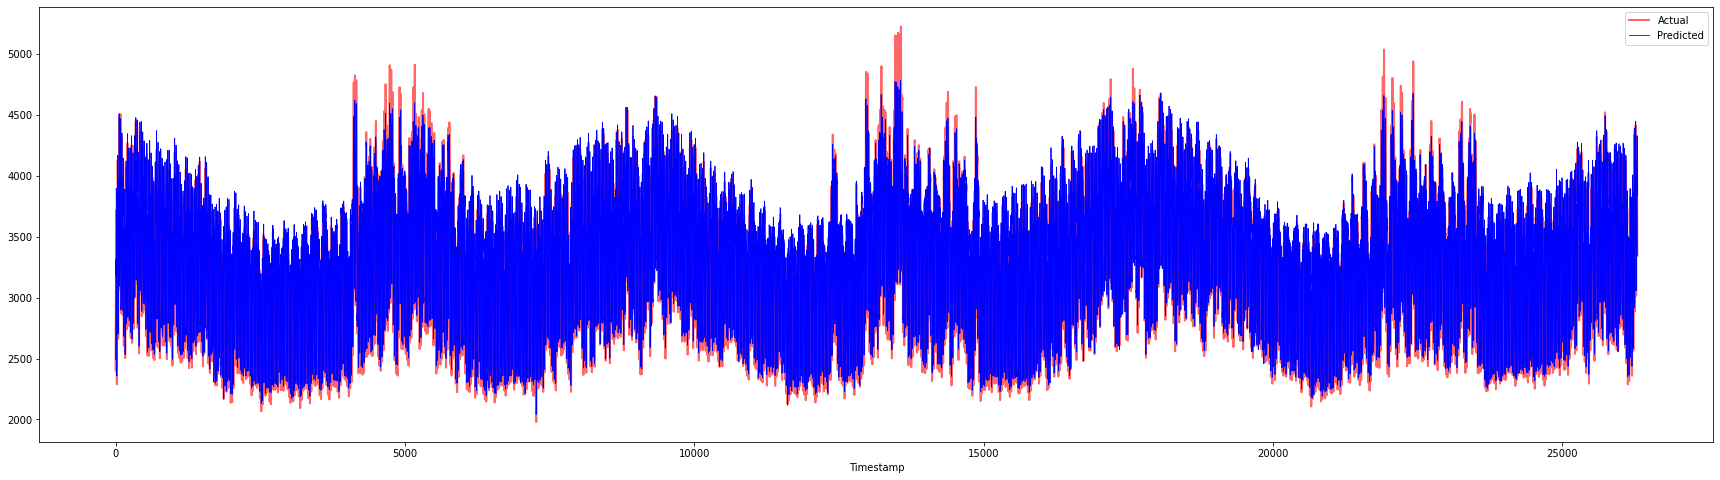

In [116]:
plt.figure(figsize=(30,8))
plt.plot(Y, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(Y_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

In [117]:
print('MAPE: ', mean_absolute_percentage_error(Y_pred, Y), '%')

MAPE:  2.0489449464303573 %
